# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [38]:
from citipy import citipy
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import requests
from pprint import pprint
from api_keys import weather_api_key
import random

In [39]:
def get_random_floats(low, high, k=1):
    """ Return a unique random floats
        in the range of low <= x <= high
    """
    result = []
    seen = set()
    for i in range(k):
        x=random.uniform(low, high)
        while x in seen:
            x=random.uniform(low, high)
        seen.add(x)
        result.append(x)
    return result

def get_random_lat():
    return random.uniform(-90, 90)

def get_random_lon():
    return random.uniform(-180, 180)

def generate_city_response(city_name):
    url=f"http://api.openweathermap.org/data/2.5/weather?q={city_name}&appid={weather_api_key}&units=imperial"
    return requests.get(url).json()

def print_city(num,city_name):
    print (f"Processing record {(num+1)%50} of set {round((num+1)/50)+1} | {city_name.capitalize()}")

def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.5)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

## Generate Cities List

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [40]:
latitudes=get_random_floats(-90,90,500)
longitudes=get_random_floats(-180,180,500)
cities_json=[]
for i in range(500):
    city=citipy.nearest_city(latitudes[i],longitudes[i])
    response_json=generate_city_response(city.city_name)
    while response_json in cities_json:
        city=citipy.nearest_city(get_random_lat(),get_random_lon())       
        response_json=generate_city_response(city.city_name)
    try:
        print_city(i,response_json['name'])
    except KeyError:
        print_city(i,city.city_name)
        print("City not found. Skipping...")
        while response_json.get("name")==None:
            city=citipy.nearest_city(get_random_lat(),get_random_lon())       
            response_json=generate_city_response(city.city_name)
            while response_json in cities_json:
                city=citipy.nearest_city(get_random_lat(),get_random_lon())       
                response_json=generate_city_response(city.city_name)
    
    cities_json.append(response_json)
print("-----------------------------\nData Retrieval Complete      \n-----------------------------")

Processing record 1 of set 1 | Rikitea
Processing record 2 of set 1 | George town
Processing record 3 of set 1 | Puerto ayora
Processing record 4 of set 1 | Balta
Processing record 5 of set 1 | Chokurdakh
Processing record 6 of set 1 | Fortuna
Processing record 7 of set 1 | Tumannyy
City not found. Skipping...
Processing record 8 of set 1 | Vaini
Processing record 9 of set 1 | Izvor
Processing record 10 of set 1 | Miramar
Processing record 11 of set 1 | Bredasdorp
Processing record 12 of set 1 | Castro
Processing record 13 of set 1 | Geraldton
Processing record 14 of set 1 | Lumsden
Processing record 15 of set 1 | Brahmapuri
City not found. Skipping...
Processing record 16 of set 1 | Hermanus
Processing record 17 of set 1 | Krasnyy chikoy
Processing record 18 of set 1 | Busselton
Processing record 19 of set 1 | Ushuaia
Processing record 20 of set 1 | Naze
Processing record 21 of set 1 | Nizhneyansk
City not found. Skipping...
Processing record 22 of set 1 | Esperance
Processing record 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [41]:
rows = [[cities_json[i]['name'],cities_json[i]['coord']['lat'],cities_json[i]['coord']['lon'],cities_json[i]['main']['temp_max'],cities_json[i]['main']['humidity'],cities_json[i]['clouds']['all'],cities_json[i]['wind']['speed'],cities_json[i]['sys']['country'],cities_json[i]['dt'] ] for i in range(500)]
df = pd.DataFrame(rows, columns=["City", "Lat","Lon","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"])
df.to_csv(r'output_data/weather.txt')
df.head()

,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Rikitea,-23.1203,-134.9692,71.69,61,100,24.11,PF,1626650728
1,George Town,5.4112,100.3354,80.89,85,20,1.14,MY,1626650729
2,Puerto Ayora,-0.7393,-90.3518,72.55,91,79,5.01,EC,1626650729
3,Balta,47.9355,29.6198,75.20,65,47,3.65,UA,1626650729
4,Chokurdakh,70.6333,147.9167,52.07,50,18,7.67,RU,1626650730


In [42]:
info=df[["Lat","Lon","Max Temp","Humidity","Cloudiness","Wind Speed","Date"]].agg(['count','mean','std','min',q25,q50,q75,'max'])
info

,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02
mean,18.434776,15.045876,69.144300,71.932000,56.004000,7.439860,1.626651e+09
std,33.591292,93.253887,14.706316,20.114387,39.381898,5.802039,1.001335e+02
min,-54.800000,-175.200000,33.570000,10.000000,0.000000,0.000000,1.626650e+09
q25,-9.524975,-68.200025,57.610000,63.750000,16.750000,3.210000,1.626651e+09
q50,21.396700,18.453300,71.700000,77.000000,67.000000,5.760000,1.626651e+09
q75,45.783325,104.091900,79.865000,86.000000,97.000000,10.360000,1.626651e+09
max,78.218600,179.316700,104.560000,100.000000,100.000000,32.550000,1.626651e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [43]:
#skipped

In [44]:
#  Get the indices of cities that have humidity over 100%.
#skipped

In [45]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
#skipped

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

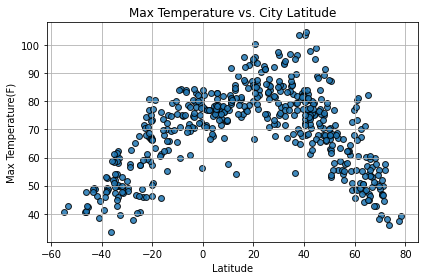

In [46]:
df.plot(kind="scatter",x="Lat",y="Max Temp",title="Max Temperature vs. City Latitude",edgecolors="black",s=35,alpha=0.85)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature(F)")
plt.tight_layout()
plt.grid()
plt.savefig("output_data/ Latitude-vs-Temp.png", dpi=100, bbox_inches='tight')
plt.show()

## Latitude vs. Humidity Plot

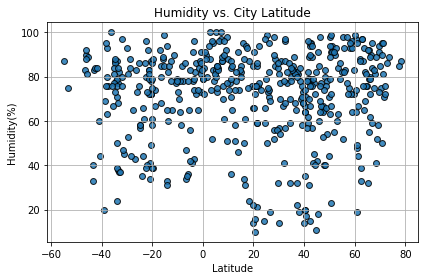

In [47]:
df.plot(kind="scatter",x="Lat",y="Humidity",title="Humidity vs. City Latitude",edgecolors="black",s=35,alpha=0.85)
plt.xlabel("Latitude")
plt.ylabel("Humidity(%)")
plt.grid()
plt.tight_layout()
plt.savefig("output_data/ Latitude-vs-Humidity.png", dpi=100, bbox_inches='tight')
plt.show()

## Latitude vs. Cloudiness Plot

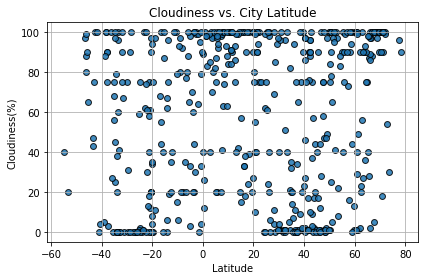

In [48]:
df.plot(kind="scatter",x="Lat",y="Cloudiness",title="Cloudiness vs. City Latitude",edgecolors="black",s=35,alpha=0.85)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness(%)")
plt.grid()
plt.tight_layout()
plt.savefig("output_data/ Latitude-vs-Cloudiness.png", dpi=100, bbox_inches='tight')
plt.show()

## Latitude vs. Wind Speed Plot

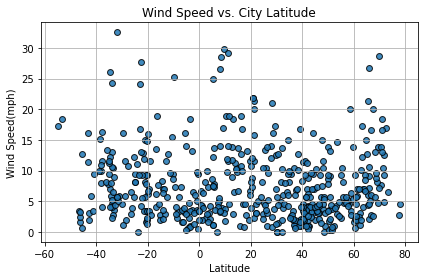

In [49]:
df.plot(kind="scatter",x="Lat",y="Wind Speed",title="Wind Speed vs. City Latitude",edgecolors="black",s=35,alpha=0.85)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed(mph)")
plt.grid()
plt.tight_layout()
plt.savefig("output_data/ Latitude-vs-Wind_Speed.png", dpi=100, bbox_inches='tight')
plt.show()

## Linear Regression

In [50]:
north_df=df.loc[df["Lat"]>0]
south_df=df.loc[df["Lat"]<0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is -0.6282467045760062


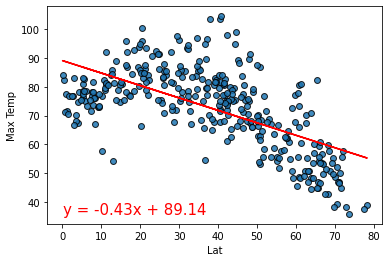

In [51]:
x1=north_df["Lat"]
(slp1,inter1,rvalue1,pvalue1,std1)=linregress(x1,north_df["Max Temp"])
print("The r-value is "+str(rvalue1))
north_df.plot(kind="scatter",x="Lat",y="Max Temp",edgecolors="black",s=35,alpha=0.85)
plt.plot(x1,inter1+slp1*x1,'r-')
line_eq = "y = " + str(round(slp1,2)) + "x + " + str(round(inter1,2))
plt.annotate(line_eq,(north_df['Lat'].min(),north_df['Max Temp'].min()),fontsize=15,color="red")
plt.savefig('output_data/Max-temp-vs-North-Lat.png')
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is 0.8036781476010307


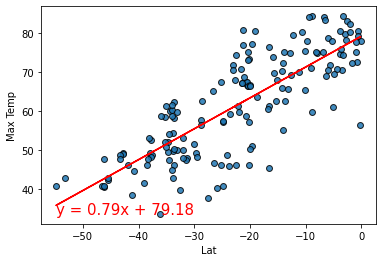

In [52]:
x2=south_df["Lat"]
(slp2,inter2,rvalue2,pvalue2,std2)=linregress(x2,south_df["Max Temp"])
print("The r-value is "+str(rvalue2))
south_df.plot(kind="scatter",x="Lat",y="Max Temp",edgecolors="black",s=35,alpha=0.85)
plt.plot(x2,inter2+slp2*x2,'r-')
line_eq2 = "y = " + str(round(slp2,2)) + "x + " + str(round(inter2,2))
plt.annotate(line_eq2,(south_df['Lat'].min(),south_df['Max Temp'].min()),fontsize=15,color="red")
plt.savefig('output_data/Max-temp-vs-South-Lat.png')
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is -0.009633609528700791


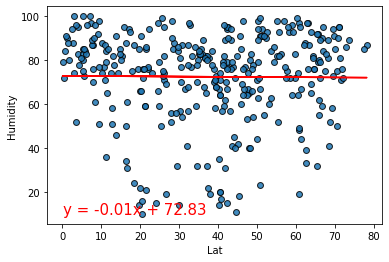

In [53]:
(slp3,inter3,rvalue3,pvalue3,std3)=linregress(x1,north_df["Humidity"])
print("The r-value is "+str(rvalue3))
north_df.plot(kind="scatter",x="Lat",y="Humidity",edgecolors="black",s=35,alpha=0.85)
plt.plot(x1,inter3+slp3*x1,'r-')
line_eq = "y = " + str(round(slp3,2)) + "x + " + str(round(inter3,2))
plt.annotate(line_eq,(north_df['Lat'].min(),north_df['Humidity'].min()),fontsize=15,color="red")
plt.savefig('output_data/Humidity-vs-North-Lat.png')
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is -0.0014949125247806887


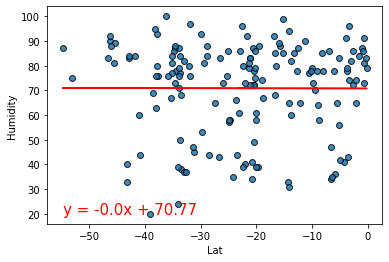

In [54]:
(slp6,inter6,rvalue6,pvalue6,std6)=linregress(x2,south_df["Humidity"])
print("The r-value is "+str(rvalue6))
south_df.plot(kind="scatter",x="Lat",y="Humidity",edgecolors="black",s=35,alpha=0.85)
plt.plot(x2,inter6+slp6*x2,'r-')
line_eq2 = "y = " + str(round(slp6,2)) + "x + " + str(round(inter6,2))
plt.annotate(line_eq2,(south_df['Lat'].min(),south_df['Humidity'].min()),fontsize=15,color="red")
plt.savefig('output_data/Humidity-vs-South-Lat.png')
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is -0.029826237332167847


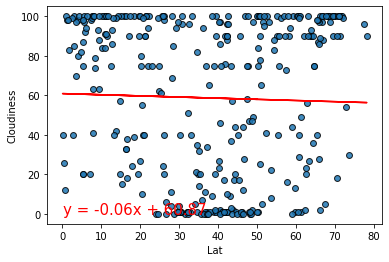

In [55]:
(slp4,inter4,rvalue4,pvalue4,std4)=linregress(x1,north_df["Cloudiness"])
print("The r-value is "+str(rvalue4))
north_df.plot(kind="scatter",x="Lat",y="Cloudiness",edgecolors="black",s=35,alpha=0.85)
plt.plot(x1,inter4+slp4*x1,'r-')
line_eq = "y = " + str(round(slp4,2)) + "x + " + str(round(inter4,2))
plt.annotate(line_eq,(north_df['Lat'].min(),north_df['Cloudiness'].min()),fontsize=15,color="red")
plt.savefig('output_data/Cloudiness-vs-North-Lat.png')
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is 0.0602466628120774


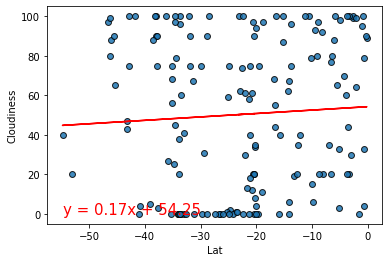

In [56]:
(slp7,inter7,rvalue7,pvalue7,std7)=linregress(x2,south_df["Cloudiness"])
print("The r-value is "+str(rvalue7))
south_df.plot(kind="scatter",x="Lat",y="Cloudiness",edgecolors="black",s=35,alpha=0.85)
plt.plot(x2,inter7+slp7*x2,'r-')
line_eq2 = "y = " + str(round(slp7,2)) + "x + " + str(round(inter7,2))
plt.annotate(line_eq2,(south_df['Lat'].min(),south_df['Cloudiness'].min()),fontsize=15,color="red")
plt.savefig('output_data/Cloudiness-vs-South-Lat.png')
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is -0.059752292432258


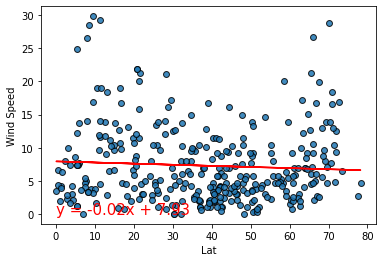

In [57]:
(slp5,inter5,rvalue5,pvalue5,std5)=linregress(x1,north_df["Wind Speed"])
print("The r-value is "+str(rvalue5))
north_df.plot(kind="scatter",x="Lat",y="Wind Speed",edgecolors="black",s=35,alpha=0.85)
plt.plot(x1,inter5+slp5*x1,'r-')
line_eq = "y = " + str(round(slp5,2)) + "x + " + str(round(inter5,2))
plt.annotate(line_eq,(north_df['Lat'].min(),north_df['Wind Speed'].min()),fontsize=15,color="red")
plt.savefig('output_data/Wind-speed-vs-North-Lat.png')
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is -0.2041064481083054


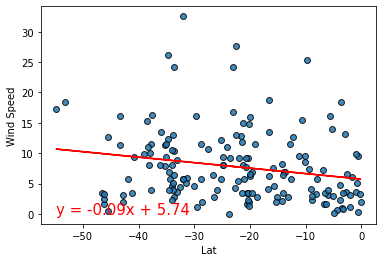

In [58]:
(slp8,inter8,rvalue8,pvalue8,std8)=linregress(x2,south_df["Wind Speed"])
print("The r-value is "+str(rvalue8))
south_df.plot(kind="scatter",x="Lat",y="Wind Speed",edgecolors="black",s=35,alpha=0.85)
plt.plot(x2,inter8+slp8*x2,'r-')
line_eq2 = "y = " + str(round(slp8,2)) + "x + " + str(round(inter8,2))
plt.annotate(line_eq2,(south_df['Lat'].min(),south_df['Wind Speed'].min()),fontsize=15,color="red")
plt.savefig('output_data/Wind-speed-vs-South-Lat.png')
plt.show()